# Energy Aware Task Migrations

In [23]:
import dataclasses
import random
import logging
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Dict


**Defining Task and Server Dataclasses**

In [ ]:
@dataclasses.dataclass

# represents a task to be executed on a server
class Task:
    id: int
    cpu_demand: float
    memory_demand: float
    energy_consumption: float = 0.0
    current_server: int = None
    priority: float = 0.0

# represents a server in the system
@dataclasses.dataclass
class Server:
    id: int
    max_cpu: float
    max_memory: float
    energy_efficiency: float
    current_tasks: list = dataclasses.field(default_factory=list)
    current_cpu_usage: float = 0.0
    current_memory_usage: float = 0.0


**Defining class for task migrations based on available storage**

In [25]:

# Handles task placement, migration, and energy consumption optimization
class EnergyAwareTaskMigrator:
    def __init__(self, servers: List[Server], tasks: List[Task], migration_threshold: float = 0.8, max_iterations: int = 5):
        logging.basicConfig(level=logging.INFO, format='%(message)s')
        self.logger = logging.getLogger(__name__)
        self.servers = {server.id: server for server in servers}
        self.tasks = tasks
        self.migration_history: List[Dict] = []
        self.total_initial_energy: float = 0.0
        self.total_final_energy: float = 0.0
        self.migration_threshold = migration_threshold
        self.max_iterations = max_iterations

    # places tasks on servers based on resource availability
    def place_initial_tasks(self):
        """Initial task placement without overcommitment"""
        sorted_tasks = sorted(self.tasks, key=lambda x: (x.priority, x.cpu_demand + x.memory_demand), reverse=True)
        
        for task in sorted_tasks:
            placed = False
            for server in self.servers.values():
                self.logger.info(f"Placing Task {task.id} on Server {server.id}")
                if (server.current_cpu_usage + task.cpu_demand <= server.max_cpu and 
                    server.current_memory_usage + task.memory_demand <= server.max_memory):
                    server.current_tasks.append(task)
                    server.current_cpu_usage += task.cpu_demand
                    server.current_memory_usage += task.memory_demand
                    task.current_server = server.id
                    task.energy_consumption = self._calculate_energy_cost(task, server)
                    placed = True
                    break
            if not placed:
                self.logger.warning(f"Task {task.id} could not be placed on any server due to insufficient resources.")

    # calculates the energy cost of running a task on a specific server
    def _calculate_energy_cost(self, task, server):
        """Calculate energy cost considering resource utilization"""
        resource_util = (task.cpu_demand / server.max_cpu + task.memory_demand / server.max_memory) / 2
        priority_factor = 1 + task.priority
        return resource_util * server.energy_efficiency * priority_factor * 100

    # Calculates total energy consumption across all servers
    def calculate_total_energy_consumption(self) -> float:
        """Calculate total energy consumption across all servers"""
        return sum(task.energy_consumption for task in self.tasks if task.current_server is not None)

    # Main Function
    # Migrates tasks to reduce energy consumption
    def optimize_task_migration(self):
        """Optimize task allocation by migrating to reduce energy usage"""
        migration_occurred = False
        sorted_tasks = sorted(self.tasks, key=lambda x: x.energy_consumption, reverse=True)
        
        for task in sorted_tasks:
            if task.current_server is None:
                continue
            
            current_server = self.servers[task.current_server]
            best_server = current_server
            min_energy_cost = task.energy_consumption
            
            for server in self.servers.values():
                if server.id == current_server.id:
                    continue
                
                if (server.current_cpu_usage + task.cpu_demand <= server.max_cpu and 
                    server.current_memory_usage + task.memory_demand <= server.max_memory):
                    new_energy_cost = self._calculate_energy_cost(task, server)
                    
                    self.logger.info(f"Task {task.id} migration check: Server {current_server.id} → Server {server.id}")
                    self.logger.info(f"Current Energy Cost: {min_energy_cost:.2f}, New Energy Cost: {new_energy_cost:.2f}")
                    
                    if new_energy_cost < min_energy_cost:
                        best_server = server
                        min_energy_cost = new_energy_cost
            
            if best_server.id != current_server.id:
                self._migrate_task(task, current_server, best_server)
                migration_occurred = True
        
        if not migration_occurred:
            self.logger.warning("No migrations occurred in this iteration.")
        return migration_occurred

    # task migrations
    def _migrate_task(self, task, source_server, target_server):
        """Migrate task from one server to another"""
        self.logger.info(f"Task {task.id} migrated from Server {source_server.id} to Server {target_server.id}")
        
        source_server.current_tasks.remove(task)
        source_server.current_cpu_usage -= task.cpu_demand
        source_server.current_memory_usage -= task.memory_demand
        
        target_server.current_tasks.append(task)
        target_server.current_cpu_usage += task.cpu_demand
        target_server.current_memory_usage += task.memory_demand
        task.current_server = target_server.id
        task.energy_consumption = self._calculate_energy_cost(task, target_server)
        
        self.migration_history.append({
            'task_id': task.id,
            'source_server': source_server.id,
            'target_server': target_server.id,
            'new_energy_cost': task.energy_consumption
        })

    # Visualizes server loads, energy consumption, and task migrations
    def visualize_results(self):
        """Visualize server load and energy consumption"""
        plt.figure(figsize=(15, 10))

        # Server Load Distribution
        plt.subplot(2, 2, 1)
        server_loads = [len(server.current_tasks) for server in self.servers.values()]
        plt.bar([f'Server {s.id}' for s in self.servers.values()], server_loads)
        plt.title('Task Distribution Across Servers')
        plt.ylabel('Number of Tasks')

        # Energy Consumption Heatmap
        plt.subplot(2, 2, 2)
        energy_matrix = np.zeros((len(self.servers), len(self.tasks)))
        for i, server in enumerate(self.servers.values()):
            for task in server.current_tasks:
                energy_matrix[i, task.id - 1] = task.energy_consumption
        plt.imshow(energy_matrix, cmap='YlOrRd', aspect='auto')
        plt.title('Energy Consumption Heatmap')
        plt.xlabel('Tasks')
        plt.ylabel('Servers')
        plt.colorbar(label='Energy Cost')

        # Migration Frequency Histogram
        plt.subplot(2, 2, 3)
        migrations_per_task = [len([m for m in self.migration_history if m['task_id'] == task.id]) for task in self.tasks]
        plt.hist(migrations_per_task, bins=range(max(migrations_per_task) + 2))
        plt.title('Task Migration Frequency')
        plt.xlabel('Number of Migrations')
        plt.ylabel('Number of Tasks')

        # Server Efficiency vs Load
        plt.subplot(2, 2, 4)
        server_efficiencies = [server.energy_efficiency for server in self.servers.values()]
        server_loads = [len(server.current_tasks) for server in self.servers.values()]
        plt.scatter(server_efficiencies, server_loads)
        plt.title('Server Efficiency vs Task Load')
        plt.xlabel('Energy Efficiency')
        plt.ylabel('Number of Tasks')

        plt.tight_layout()
        plt.show()

    def run_simulation(self):
        """Run the simulation"""
        self.place_initial_tasks()
        self.total_initial_energy = self.calculate_total_energy_consumption()
        self.logger.info(f"Initial Total Energy Consumption: {self.total_initial_energy:.2f}")
        
        for iteration in range(self.max_iterations):
            self.logger.info(f"\n--- Migration Iteration {iteration + 1} ---")
            if not self.optimize_task_migration():
                break

        self.total_final_energy = self.calculate_total_energy_consumption()
        self.logger.info(f"Final Total Energy Consumption: {self.total_final_energy:.2f}")
        
        energy_savings = ((self.total_initial_energy - self.total_final_energy) / self.total_initial_energy) * 100
        self.logger.info(f"Energy Savings: {energy_savings:.2f}%")
        
        self.visualize_results()




**Several Environments created for testing**

In [ ]:
# small env for debugging
def create_minimal_environment():
    """Create a small test environment for debugging"""
    servers = [
        Server(id=1, max_cpu=16, max_memory=64, energy_efficiency=0.8),
        Server(id=2, max_cpu=24, max_memory=96, energy_efficiency=0.6),
        Server(id=3, max_cpu=32, max_memory=128, energy_efficiency=0.4),
    ]
    tasks = [
        Task(id=1, cpu_demand=8, memory_demand=32, priority=0.9),
        Task(id=2, cpu_demand=12, memory_demand=48, priority=0.8),
        Task(id=3, cpu_demand=4, memory_demand=16, priority=0.7),
        Task(id=4, cpu_demand=10, memory_demand=40, priority=0.6),
        Task(id=5, cpu_demand=6, memory_demand=24, priority=0.5),
    ]
    return servers, tasks

In [27]:
# balanced scenario with evenly distributed resources
def create_balanced_environment():
    """Create a balanced test environment"""
    servers = [
        Server(id=1, max_cpu=32, max_memory=128, energy_efficiency=0.7),
        Server(id=2, max_cpu=28, max_memory=112, energy_efficiency=0.8),
        Server(id=3, max_cpu=36, max_memory=144, energy_efficiency=0.6),
    ]
    tasks = [
        Task(id=1, cpu_demand=10, memory_demand=40, priority=0.8),
        Task(id=2, cpu_demand=12, memory_demand=48, priority=0.7),
        Task(id=3, cpu_demand=8, memory_demand=32, priority=0.6),
        Task(id=4, cpu_demand=14, memory_demand=56, priority=0.9),
        Task(id=5, cpu_demand=16, memory_demand=64, priority=0.5),
        Task(id=6, cpu_demand=6, memory_demand=24, priority=0.4),
    ]
    return servers, tasks


In [29]:
# env where tasks require high resources
def create_high_demand_environment():
    """Create a high-demand test environment"""
    servers = [
        Server(id=1, max_cpu=16, max_memory=64, energy_efficiency=0.9),
        Server(id=2, max_cpu=20, max_memory=80, energy_efficiency=0.8),
        Server(id=3, max_cpu=24, max_memory=96, energy_efficiency=0.7),
    ]
    tasks = [
        Task(id=1, cpu_demand=14, memory_demand=56, priority=0.8),
        Task(id=2, cpu_demand=16, memory_demand=64, priority=0.9),
        Task(id=3, cpu_demand=12, memory_demand=48, priority=0.7),
        Task(id=4, cpu_demand=18, memory_demand=72, priority=0.6),
        Task(id=5, cpu_demand=10, memory_demand=40, priority=0.5),
        Task(id=6, cpu_demand=20, memory_demand=80, priority=0.4),
    ]
    return servers, tasks

In [31]:
# resources constrained servers
def create_low_resource_environment():
    """Create a low-resource test environment"""
    servers = [
        Server(id=1, max_cpu=8, max_memory=32, energy_efficiency=0.9),
        Server(id=2, max_cpu=12, max_memory=48, energy_efficiency=0.8),
        Server(id=3, max_cpu=16, max_memory=64, energy_efficiency=0.7),
    ]
    tasks = [
        Task(id=1, cpu_demand=6, memory_demand=24, priority=0.7),
        Task(id=2, cpu_demand=8, memory_demand=32, priority=0.8),
        Task(id=3, cpu_demand=4, memory_demand=16, priority=0.5),
        Task(id=4, cpu_demand=10, memory_demand=40, priority=0.6),
    ]
    return servers, tasks

In [35]:
# high demand + low resources tasks
def create_diverse_environment():
    """Create a diverse test environment"""
    servers = [
        Server(id=1, max_cpu=32, max_memory=128, energy_efficiency=0.9),
        Server(id=2, max_cpu=24, max_memory=96, energy_efficiency=0.6),
        Server(id=3, max_cpu=40, max_memory=160, energy_efficiency=0.8),
        Server(id=4, max_cpu=16, max_memory=64, energy_efficiency=0.7),
    ]
    tasks = [
        Task(id=1, cpu_demand=8, memory_demand=32, priority=0.9),
        Task(id=2, cpu_demand=12, memory_demand=48, priority=0.7),
        Task(id=3, cpu_demand=20, memory_demand=80, priority=0.6),
        Task(id=4, cpu_demand=6, memory_demand=24, priority=0.8),
        Task(id=5, cpu_demand=10, memory_demand=40, priority=0.5),
        Task(id=6, cpu_demand=14, memory_demand=56, priority=0.4),
        Task(id=7, cpu_demand=18, memory_demand=72, priority=0.3),
    ]
    return servers, tasks

Placing Task 1 on Server 1
Placing Task 4 on Server 1
Placing Task 2 on Server 1
Placing Task 3 on Server 1
Placing Task 3 on Server 2
Placing Task 5 on Server 1
Placing Task 5 on Server 2
Placing Task 5 on Server 3
Placing Task 6 on Server 1
Placing Task 6 on Server 2
Placing Task 6 on Server 3
Placing Task 7 on Server 1
Placing Task 7 on Server 2
Placing Task 7 on Server 3
Placing Task 7 on Server 4
Task 7 could not be placed on any server due to insufficient resources.
Initial Total Energy Consumption: 279.70

--- Migration Iteration 1 ---
Task 2 migration check: Server 1 → Server 3
Current Energy Cost: 57.38, New Energy Cost: 40.80
Task 2 migration check: Server 1 → Server 4
Current Energy Cost: 40.80, New Energy Cost: 89.25
Task 2 migrated from Server 1 to Server 3
Task 1 migration check: Server 1 → Server 4
Current Energy Cost: 42.75, New Energy Cost: 66.50
Task 6 migration check: Server 3 → Server 1
Current Energy Cost: 39.20, New Energy Cost: 55.12
Task 6 migration check: Serve

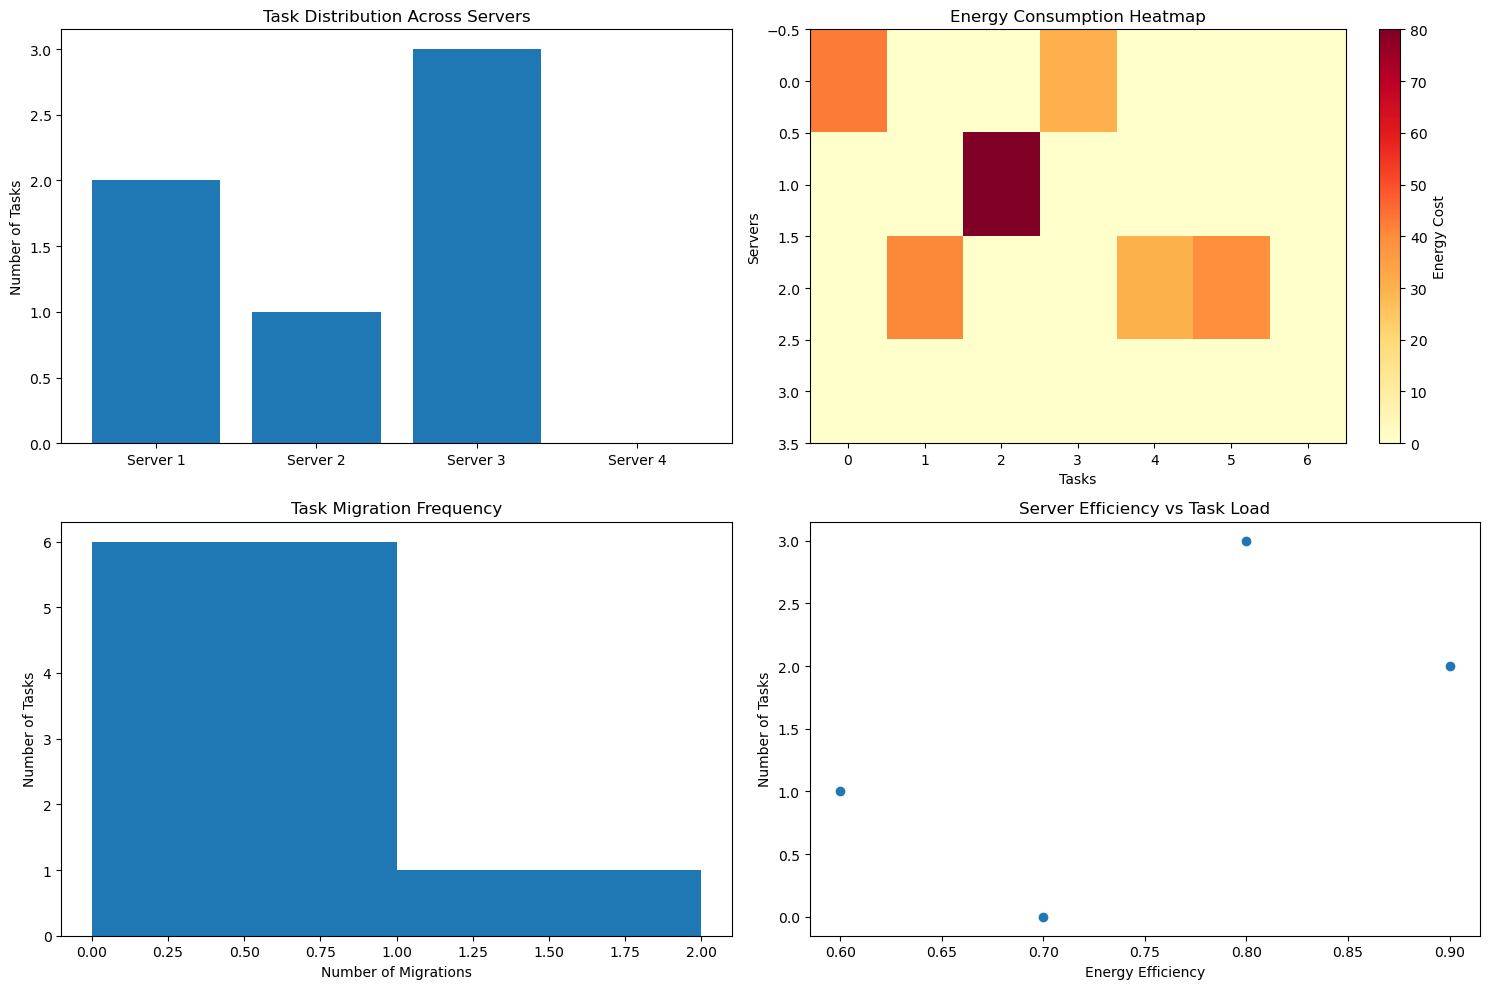

In [37]:
def main():
    servers, tasks = create_minimal_environment()
    # servers, tasks = create_balanced_environment()
    # servers, tasks = create_high_demand_environment()
    # servers, tasks = create_low_resource_environment()
    # servers, tasks = create_diverse_environment()
    migrator = EnergyAwareTaskMigrator(servers, tasks)
    migrator.run_simulation()

if __name__ == "__main__":
    main()